In [1]:
%matplotlib inline

# CenterNet (AkidaNet18)/PASCAL-VOC detection example

This example demonstrates Akida's object detection capabilities using the CenterNet (AkidaNet18) architecture.

### 1. Import model

The model used for this demonstration can be found at the [Akida 2.0 Model Zoo](https://doc.brainchipinc.com/model_zoo_performance.html#id4). It has been pre-downloaded and converted to Akida here for efficiency.

In [2]:
from akida import Model

model_akida = Model("models/centernet_akidanet18_voc_384_i8_w8_a8.fbz")
model_akida.summary()

                 Model Summary                  
________________________________________________
Input shape    Output shape  Sequences  Layers
[384, 384, 3]  [96, 96, 24]  1          41    
________________________________________________

_________________________________________________________________________________________
Layer (type)                                            Output shape   Kernel shape    

======================== SW/convnext_stem-dequantizer (Software) ========================

convnext_stem (InputConv2D)                             [96, 96, 64]   (4, 4, 3, 64)   
_________________________________________________________________________________________
stage_0/conv_0 (Conv2D)                                 [96, 96, 64]   (3, 3, 64, 64)  
_________________________________________________________________________________________
stage_0/conv_1 (Conv2D)                                 [96, 96, 64]   (3, 3, 64, 64)  
____________________________________________

### 2. Map the model onto the FPGA

For more details on this flow, please see: [Model Hardware Mapping](https://doc.brainchipinc.com/user_guide/akida.html#model-hardware-mapping)

In [3]:
import akida
from cnn2snn import set_akida_version, AkidaVersion
# Instantiate akida model
with set_akida_version(AkidaVersion.v2):
    devices = akida.devices()
    if len(devices) > 0:
        print(f'Available devices: {[dev.desc for dev in devices]}')
        device = devices[0]
        print(device.version)
        try:
            model_akida.map(device)
            print(f"Mapping to Akida device {device.desc}.")
        except Exception as e:
            print("Model not compatible with FPGA. Running on CPU.")
    else:
        print("No Akida devices found, running on CPU.")


2025-08-21 14:48:17.434928: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-21 14:48:17.456983: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-21 14:48:17.457000: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-21 14:48:17.457585: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-21 14:48:17.461212: I tensorflow/core/platform/cpu_feature_guar

Available devices: ['fpga-1691']
BC.A2.001.000
Mapping to Akida device fpga-1691.


### Model Summary After Mapping

In [4]:
model_akida.summary()

                                      Model Summary                                      
_________________________________________________________________________________________
Input shape    Output shape  Sequences  Layers  NPs  Skip DMAs  External Memory (Bytes)
[384, 384, 3]  [96, 96, 24]  3          41      36   0          0                      
_________________________________________________________________________________________

_________________________
Component (type)  Count
HRC               1    
_________________________
CNP1              36   
_________________________

_____________________________________________________________________________________________________
Layer (type)                                            Output shape   Kernel shape      Components

================== HW/convnext_stem-stage_0/conv_1 (Hardware) - size: 911380 bytes ==================

convnext_stem (InputConv2D)                             [96, 96, 64]   (4, 4, 3, 64)     1 HRC  

### 3 Load the sample image data

Similar to the model, the sample image data and associated anchors have been pre-downloaded for efficiency. You can learn more about the CenterNet data that is available by referencing the [Developer MetaTF API Reference](https://doc.brainchipinc.com/api_reference/akida_models_apis.html#centernet). 

In [5]:
import tensorflow as tf
import pickle

# Helper function to load and parse the Tfrecord file.
def load_tf_dataset(tf_record_file_path):
    tfrecord_files = [tf_record_file_path]

    # Feature description for parsing the TFRecord
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'objects/bbox': tf.io.VarLenFeature(tf.float32),
        'objects/label': tf.io.VarLenFeature(tf.int64),
    }

    def _count_tfrecord_examples(dataset):
        return len(list(dataset.as_numpy_iterator()))

    def _parse_tfrecord_fn(example_proto):
        example = tf.io.parse_single_example(example_proto, feature_description)

        # Decode the image from bytes
        example['image'] = tf.io.decode_jpeg(example['image'], channels=3)

        # Convert the VarLenFeature to a dense tensor
        example['objects/label'] = tf.sparse.to_dense(example['objects/label'], default_value=0)

        example['objects/bbox'] = tf.sparse.to_dense(example['objects/bbox'])
        # Boxes were flattenned that's why we need to reshape them
        example['objects/bbox'] = tf.reshape(example['objects/bbox'],
                                             (tf.shape(example['objects/label'])[0], 4))
        # Create a new dictionary structure
        objects = {
            'label': example['objects/label'],
            'bbox': example['objects/bbox'],
        }

        # Remove unnecessary keys
        example.pop('objects/label')
        example.pop('objects/bbox')

        # Add 'objects' key to the main dictionary
        example['objects'] = objects

        return example

    # Create a TFRecordDataset
    dataset = tf.data.TFRecordDataset(tfrecord_files)
    len_dataset = _count_tfrecord_examples(dataset)
    parsed_dataset = dataset.map(_parse_tfrecord_fn)

    return parsed_dataset, len_dataset


labels = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
          'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse',
          'motorbike', 'person', 'pottedplant', 'sheep', 'sofa',
          'train', 'tvmonitor']

val_dataset, len_val_dataset = load_tf_dataset("datasets/test_20_classes.tfrecord")
print(f"Loaded VOC2007 sample test data: {len_val_dataset} images.")

#with open("datasets/coco_anchors.pkl", 'rb') as handle:
#        anchors = pickle.load(handle)
#print(f"Loaded anchors")

Loaded VOC2007 sample test data: 100 images.


### 4 Run inference on a random image

Here, a random image is selected from the sample test data. The image is preprocessed and evaluated through the Akida model. Bounding boxes for detected objects are returned and superimposed on the image using the anchors.

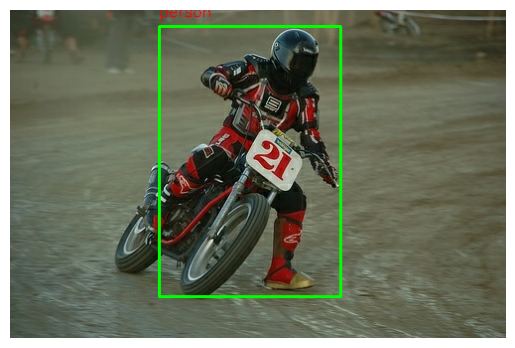

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from akida_models.detection.processing import preprocess_image
from akida_models.centernet.centernet_processing import decode_output

import cv2

# Shuffle the data to take a random test image
val_dataset = val_dataset.shuffle(buffer_size=len_val_dataset)

input_shape = model_akida.layers[0].input_dims

# Load the image
raw_image = next(iter(val_dataset))['image']

# Keep the original image size for later bounding boxes rescaling
raw_height, raw_width, _ = raw_image.shape

# Pre-process the image
image = preprocess_image(raw_image, input_shape)
input_image = image[np.newaxis, :].astype(np.uint8)

output_img = np.copy(raw_image)

# Call evaluate on the image
pots = model_akida.predict(input_image)[0]

bounding_boxes = decode_output(pots,
                        20,
                        obj_threshold=0.4,
                        max_detections=100,
                        kernel=5)
            
for box in bounding_boxes:
        output_img = cv2.rectangle( output_img, 
                    (int(box.x1 * raw_width), int(box.y1 * raw_height)),
                    (int(box.x2 * raw_width), int(box.y2 * raw_height)),
                    color=(0, 255, 0),
                    thickness=2)
        output_img = cv2.putText(output_img,
                    f'{labels[box.get_label()]}',
                    (int(box.x1 * raw_width), int(box.y1 * raw_height - 10)),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.5,
                    (255, 0, 0),
                    1)

fig = plt.figure(num='VOC detection by Akida')
ax = fig.subplots(1)
img_plot = ax.imshow(np.zeros(output_img.shape, dtype=np.uint8))
img_plot.set_data(output_img)

plt.axis('off')
plt.show()

### 5 Model Statistics

The advantage of running on a FPGA is the ability to accurately calculate performance, power and area metrics for a given model and process node.

Here are example calculations for the CenterNet model that was tested above.

#### Performance

This Akida 6-Node FPGA is running at __25 MHz__. Based on that knowledge, we need to know the frames per second on the FPGA. The `akida.Model.statistics.fps` will return this value.

In [7]:
akida_fpga_mhz = 25  # MHz
fps = model_akida.statistics.fps
print(f"FPS @ {akida_fpga_mhz} MHz: {fps}")

FPS @ 25 MHz: 1.1210762331838564


To estimate frames per second at a different frequency use the calculation:

$$ \frac{\text{estimated\_fps}}{\text{estimated\_mhz}} = \frac{\text{fps}}{\text{akida\_fpga\_mhz}}$$

$$\text{estimated\_fps} = \frac{\text{fps} \times \text{estimated\_mhz}}{\text{akida\_fpga\_mhz}} $$


In [8]:
estimated_mhz = 400  # Change this to your desired frequency
estimated_fps = (fps * estimated_mhz) / akida_fpga_mhz
print(f"Estimated FPS @ {estimated_mhz} MHz: {estimated_fps}")

Estimated FPS @ 400 MHz: 17.937219730941703


#### Power

Estimating power consumption of a model involves understanding the architecture and size of the model (e.g. # parameters, types of layer operations, etc) as well as a target process node (e.g. TSMC 28nm, Global Foundry 22nm, etc) and target chip frequency (e.g. 400 MHz, 1 GHz, etc).

Brainchip's Solution Architects have access to up to date calculations for the Akida 2.0 Register-transfer-level (RTL) and can perform estimates for your particular model. Contact your BrainChip representative when you have a model ready for estimating.

We will use BrainChip's calculations for the CenterNet (AkidaNet 18 backbone, 2.4M parameters, 384x384 resolution) here to illustrate power consumption.

Consider the following formula:

$$ \text{Total Power (W)} = \frac{\text{Energy per Inference (J)}}{\text{Time per Inference (s)}} \times \text{Frames per Second} $$

and CenterNet (AkidaNet 18 backbone, 2.4M parameters, 384x384 resolution) Energy per inference = 38.46 mJ while running 400 MHz.

The calculation for Total Power is:


In [9]:
centernet_energy_per_infernence_mJ = 38.46  # Change this to your measured energy per inference in mJ

total_power_mw = (centernet_energy_per_infernence_mJ * estimated_fps) / 1000  # Convert mJ to mW

print(f"Estimated IP Total Power: {total_power_mw:.2f} mW at {estimated_mhz} MHz")

Estimated IP Total Power: 0.69 mW at 400 MHz


#### Area

Similar to power, estimating the area size required for a chip to run a model involves understanding the architecture and size of the model (e.g. # parameters, types of layer operations, etc) as well as a target process node (e.g. TSMC 28nm, Global Foundry 22nm, etc) and the ability to leverage RTL options such Hardware Partial Reconfiguration.

A model that executes successfully on the FPGA is capable of receiving accurate sizing estimations. BrainChip's Solution Architects can assist with these calculations.

For this CenterNet (AkidaNet18) example, BrainChip has calculated the area for Global Foundry 22nm:

| Specification       | Value  |
|---------------------|--------|
| Logic Gate Count (M)| 193.86 |
| Memory Size (KB)    | 43042  |
| Logic Area (mm²)    | 36.77  |
| Memory Area (mm²)   | 65.53  |
| Total Area (mm²)    | 102.3  |


### Note: Once you’ve finished running the notebook, ***"Uncomment and run the cell below"*** to release the device and free it up for further experiments.

In [10]:
# import os
# os._exit(00)

#### You can also use this button to reset your kernel

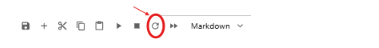